## Monolingual Norec experiments with xlmroberta
Targeted sentiment analysis with simpletransformers for sequence tagging. Highly recommend to do this in a dedicated Python environment. You need PyTorch to interact with Cuda, and Simpletransformers to interact with pytorch, and you need the right Python version to support this chain. I suggest you begin with having a Cuda version that is listed in the pytorch installation guide, and take it from there. 

This notebook was used for checking out the xlmroberta. 
Make sure you comment out or in the xlmroberta or bert parameters `family` and `transformersmodel`.


At the end, there is a cell which reads the results for each epoch during training and plots it.

In [4]:
from simpletransformers.ner import NERModel, NERArgs
import torch
import pandas as pd
import pickle as pk
import os
import random
import json
import time, datetime
random.seed(64)
# import nltk
import re
# from nltk.tokenize.simple import SpaceTokenizer
from helpers import *

print(f"Cuda: {torch.cuda.is_available()}")

Cuda: True


## Prepare the data.
I collect the experiments to run as a list of tuples. Each experiment consists of training set and testing set, and a list of tags. This list of tags is used only for checking that the files have the tags we expect. Highly recommend to do this checking, that we have the expected tags in the datasets. Token and tags need to be spaceseparated

In [5]:
datasets = [("data/spaceseparated/norec_fine/norec_fine_train.conll", 'data/spaceseparated/norec_fine/norec_fine_test.conll', ['I-targ-negative', 'I-targ-positive',
 'B-targ-negative', 'B-targ-positive', 'O'])]
'''
datasets = [
 ( "data/spaceseparated/norec_fine_nopolarity/nopol_norec_fine_train.conll"
 , "data/spaceseparated/norec_fine_nopolarity/nopol_norec_fine_dev.conll",
  ['I-targ', 'B-targ',  'O'] )] # To not repeat the first which was successful
'''
for train_path, dev_path, tags in datasets:
    for path in [dev_path,train_path]:
        with open (path) as rf:
            text = rf.read()
            # print(path)
            # print(tags)
            assert tagsset(text, separator = " ") == set(tags), tagsset(text, separator = " ")
print("Tags checked OK")
#Three identical experiments:
datasets = [s for s in datasets for _ in range(1)]
print(f"{len(datasets)} experiments prepared")

Tags checked OK
1 experiments prepared


## Perform the fine-tuning
Note that this script does not automatically  create the folders needed to save the model and to record the output. I recommend you run the following cell with 1 epoch to see that this works, befor setting it back to 8 or whatever you consider to be adequate. 3 should be enough, but I got a litte better result with 8 so I kept that.

Simpletransformers has included the code for wandb but I have not tried to connect and use that what is supposed to be a great reporting and logging tool.

Note that if you run many epochs and save the models, you will need a lot of space.

In [6]:
# Run bert multilingual with the data from previous cell

family = "bert" #'xlmroberta' # "bert"
transformersmodel = 'bert-base-multilingual-cased' #'xlm-roberta-base' #'bert-base-multilingual-cased'
results = []

for train_path, dev_path, tags in datasets:
    out_d = "outputs/simpletransformers/"+transformersmodel+"_"+train_path.split("/")[-2]
    model_args = NERArgs() # New args loading fall 2020
    model_args.train_batch_size = 32 # Should be 32 but trying 16 to not be out of memory.
    model_args.num_train_epochs = 16
    model_args.weight_decay = 0.001
    model_args.overwrite_output_dir = True
    model_args.silent = False
    model_args.save_steps = 200000
    model_args.evaluate_during_training = True
    model_args.best_model_dir = os.path.join(out_d, "best_model")

    model = NERModel(family,transformersmodel , labels = tags,args=model_args)

    
    running = os.path.join(out_d, "running") # Logging individual results
    if not os.path.exists(os.path.dirname(running)):
        os.makedirs(os.path.dirname(running))


    model.train_model(train_path, output_dir = out_d, eval_data = dev_path)
    print(transformersmodel, "Done training")

    result, model_outputs, predictions = model.eval_model(dev_path)

    #Record settings and results
    result["train"] = train_path
    result["dev_test"] = dev_path
    result["training_epochs"] = model_args.num_train_epochs
    result["transformer_model"] = transformersmodel
    json_path = os.path.join(running,"result_"+datetime.datetime.now().strftime("%Y%m%d%H%M")+".json")
    if not os.path.exists(os.path.dirname(json_path)):
        os.makedirs(os.path.dirname(json_path))
    with open(json_path, "w") as wf:
        json.dump(result, wf)
    results.append(result)
    with open(os.path.join(running, "norec_fine_mono_predictions" + datetime.datetime.now().strftime("%Y%m%d%H%M")+".json" ), "w") as wf:
        json.dump(predictions, wf)

json_path = "summaries/results_"+datetime.datetime.now().strftime("%Y%m%d%H%M")+".json"
if not os.path.exists(os.path.dirname(json_path)):
    os.makedirs(os.path.dirname(json_path))
with open(json_path, "w") as wf:
    json.dump(results, wf)
df = pd.DataFrame.from_dict(results)



Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.93 GiB total capacity; 2.08 GiB already allocated; 32.19 MiB free; 2.13 GiB reserved in total by PyTorch)

In [ ]:
# Run all above
df

In [ ]:
df.to_csv("summaries/norec_mbert.csv")

In [ ]:
## Inference
First on the existing model, then an example of how to load a saved model

In [ ]:
predictions, raw_outputs = model.predict (["Mannen på scenen synger stygt", "Damen på scenen synger stygt" , "Disse bilene har et fantastisk veigrep"])
for sentence in predictions:
    print(sentence)
    # print(json.dumps(sentence, indent=3, ensure_ascii=False))


In [ ]:
# out_d: 'outputs/simpletransformers/bert-base-multilingual-cased_norec_fine'
out_d = "outputs/simpletransformers/xlm-roberta-base_norec_fine"
family = 'xlmroberta' # "bert"
transformersmodel = 'xlm-roberta-base' #'bert-base-multilingual-cased'
last_epoch= sorted([f for f in os.listdir(out_d) if "-" in f], key = lambda x: int(x.split("-")[-1]) )[-1]
print(last_epoch)
model2 = NERModel(family, os.path.join(out_d, last_epoch))

In [ ]:
predictions, raw_outputs = model2.predict (["Mannen på scenen synger stygt", "Damen på scenen synger stygt" , "Disse bilene har et fantastisk veigrep"])
for sentence in predictions:
    print(sentence)

,epoch,eval_loss,f1_score,precision,recall
6,1,0.192236,0.233716,0.394822,0.165986
14,2,0.185571,0.284512,0.373068,0.229932
15,3,0.211736,0.327273,0.351562,0.306122
0,4,0.249927,0.315217,0.367089,0.276190
1,5,0.272711,0.353254,0.345006,0.361905
2,6,0.303015,0.350163,0.436105,0.292517
3,7,0.335823,0.334333,0.372287,0.303401
4,8,0.342925,0.375267,0.392857,0.359184
5,9,0.369390,0.372679,0.363519,0.382313
7,10,0.369381,0.370753,0.405493,0.341497


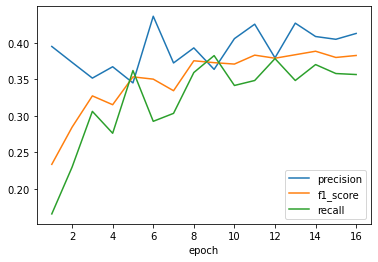

In [1]:
# Collect results from experiements that were evaluated each epoch
import matplotlib.pyplot as plt
import pandas as pd # To avoid redoing the entire notebook
%matplotlib inline
results = []
root_folder = "outputs/simpletransformers/bert-base-multilingual-cased_norec_fine"#"outputs/simpletransformers/xlm-roberta-base_norec_fine"
for subfolder in os.listdir(root_folder):
    if "checkpoint" in subfolder and "epoch" in subfolder and os.path.exists(os.path.join(root_folder, subfolder, "eval_results.txt")):
        results_file = os.path.join(root_folder, subfolder, "eval_results.txt")
        with open(results_file) as rf:
            result = {"epoch": int(subfolder.split("-")[-1])}
            for line in rf.readlines():
                if line.startswith("eval_loss"): result["eval_loss"] = float(line.split()[-1].strip())
                if line.startswith("f1_score"): result["f1_score"] = float(line.split()[-1].strip())
                if line.startswith("precision"): result["precision"] = float(line.split()[-1].strip())
                if line.startswith("recall"): result["recall"] = float(line.split()[-1].strip())
            results.append(result)
df3 = pd.DataFrame.from_dict(results)
df3.sort_values("epoch").plot(x="epoch", y=["precision","f1_score", "recall"])
df3.sort_values("epoch")